<font size = 6>EM Applications and its Extension - GMM with CVaR constraints</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Nov 9, 2022</div></font>

In [1]:
import os
os.add_dll_directory("C:\Program Files\PSG\lib")

from hmmlearn.hmm import GaussianHMM as HMM
from sklearn.mixture import GaussianMixture as GMM
from scipy import integrate
from scipy.stats import norm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import math
import numpy as np
import pandas as pd
import psgpython
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns

data_path = "D:\\Data\\"

In [2]:
def gen_norm_pdf(hmm_model, range_std = 3):
    mean_vec = hmm_model_y.means_.flatten()
    sigma_vec = np.sqrt(hmm_model_y.covars_.flatten())
    lo_vec = mean_vec - range_std * sigma_vec
    up_vec = mean_vec + range_std * sigma_vec
    x_vec = np.linspace(lo_vec.min(), up_vec.max(), int(1e5))
    y_vecs = []
    for i in range(mean_vec.shape[0]):
        curr_dist = norm(mean_vec[i], sigma_vec[i])
        y_vecs.append(curr_dist.pdf(x_vec))
    return np.array(x_vec), np.array(y_vecs), mean_vec, sigma_vec

In [3]:
def discrete_cvar(loss_vec, alpha, dist = "Uniform"):
    if dist != "Uniform":
        raise Exception("Only Accept Uniform Distribution!")

    data = np.sort(loss_vec)[::-1]
    alpha = 1 - alpha
    num = data.shape[0] - 1
    
    if int(num * alpha) == 0:
        raise Exception("Confidnece Level Alpha is not reasonable and is too large!")
    
    # Calculate VaR
    if math.isclose(int(num * alpha), num * alpha, rel_tol=1e-8):
        var_num = int(num * alpha)
        var = data[var_num]    
    else:
        var_num = int(num * alpha)
        right = num * alpha - int(num * alpha)
        left = 1 - right
        var = left * data[var_num + 1] + right * data[var_num]
    # Calculate CVaR+ and CVaR-
    if math.isclose(int(num * alpha), num * alpha, rel_tol=1e-8):
        cvar_plus_num = int(num * alpha) - 1
        cvar_minus_num = int(num * alpha)
    else:
        cvar_plus_num = int(num * alpha)
        cvar_minus_num = int(num * alpha)
    cvar_plus = np.mean(data[:cvar_plus_num + 1])
    cvar_minus = np.mean(data[:cvar_minus_num + 1])
    # Calculate lambda
    phi = 1 - int(num * alpha) / num
    lambda_ = (phi - (1 - alpha)) / alpha
    cvar = var * lambda_ + cvar_plus * (1 - lambda_)
    return cvar, var, cvar_plus, cvar_minus, lambda_

In [4]:
def cvar_single_norm(mean, sigma, alpha):
    norm_dist = norm(mean, sigma)
    return (1 / (1 - alpha)) * integrate.quad(lambda x: x * norm_dist.pdf(x), norm_dist.ppf(alpha), np.inf)[0]

In [5]:
def GMM_Model(weight, mean, sigma):
    GMM_model = pd.DataFrame({"mean": mean, "sigma": sigma, "weight": weight}).sort_values(by = "weight", ascending = False)
    GMM_model.reset_index(drop = True, inplace = True)
    return GMM_model

In [6]:
def GMM_pdf(weight, mean, sigma, x_vec):
    GMM_model = GMM_Model(weight, mean, sigma)
    
    y_vec = np.array([0.] * x_vec.shape[0])
    for i in range(GMM_model.shape[0]):
        norm_dist = norm(GMM_model["mean"][i], GMM_model["sigma"][i])
        y_vec += GMM_model["weight"][i] * norm_dist.pdf(x_vec)
    
    return y_vec

In [7]:
def GMM_cdf(weight, mean, sigma, x_vec):
    GMM_model = GMM_Model(weight, mean, sigma)
    
    y_vec = np.array([0.] * x_vec.shape[0])
    for i in range(GMM_model.shape[0]):
        norm_dist = norm(GMM_model["mean"][i], GMM_model["sigma"][i])
        y_vec += GMM_model["weight"][i] * norm_dist.cdf(x_vec)
    
    return y_vec

In [8]:
def GMM_range(weight, mean, sigma, range_std = 4, prec = 1e-5):
    # If it is used to calculate CVaR, range_std must be 4!!
    GMM_model = GMM_Model(weight, mean, sigma)
    
    GMM_model_temp = GMM_model.copy()
    GMM_model_temp["upper_bound"] = GMM_model_temp["mean"] + range_std * GMM_model_temp["sigma"]
    GMM_model_temp["lower_bound"] = GMM_model_temp["mean"] - range_std * GMM_model_temp["sigma"] 
    up = GMM_model_temp["upper_bound"].max()
    lo = GMM_model_temp["lower_bound"].min()

    x_vec = np.linspace(lo, up, int(np.ceil((up - lo) / prec)))
    return x_vec

In [9]:
def GMM_ppf(weight, mean, sigma, alpha, prec = 1e-5):
    # ppf can be also defined as VaR
    GMM_model = GMM_Model(weight, mean, sigma)
    
    x_vec = GMM_range(weight, mean, sigma, prec)
    cdf_vec = GMM_cdf(weight, mean, sigma, x_vec)
    ppf = x_vec[-(cdf_vec > alpha).sum():][0]
    
    return ppf, prec

In [10]:
def GMM_cvar(weight, mean, sigma, alpha, ppf_prec = 1e-5):
    GMM_model = GMM_Model(weight, mean, sigma)

    x_vec = GMM_range(weight, mean, sigma, 4, ppf_prec)
    pdf_vec = GMM_pdf(weight, mean, sigma, x_vec)
    cdf_vec = GMM_cdf(weight, mean, sigma, x_vec)
    
    step = x_vec[1] - x_vec[0]
    coef = cdf_vec[-(cdf_vec > alpha).sum():][-1] - cdf_vec[-(cdf_vec > alpha).sum():][0]
    approx_up = (x_vec[-(cdf_vec > alpha).sum() + 1:] * pdf_vec[-(cdf_vec > alpha).sum() + 1:]).sum() * step / coef
    approx_lo = (x_vec[-(cdf_vec > alpha).sum() : -1] * pdf_vec[-(cdf_vec > alpha).sum() : -1]).sum() * step / coef
    error = approx_up - approx_lo

    return approx_up, error

# Gaussian Mixture Model with CVaR distance and CVaR constraints

In [35]:
vector_param = np.array(Alpha[::-1])
vector_lb = np.ascontiguousarray(results["Empirical"].values[::-1])
vector_yi = np.ascontiguousarray(return_30min.values)
vector_qi = np.array([1 / return_30min.shape[0]] * return_30min.shape[0])

header = ["id"] + ["s" + str(s) for s in range(1, GMM_model.shape[0] + 1)]
matrix_ss = [header + ['scenario_benchmark'], np.array([1.] + [1.] * GMM_model.shape[0] + [0.])]
matrix_mn = [header, np.ascontiguousarray([1.] + list(GMM_model["mean"].values))]
matrix_vr = [header, np.ascontiguousarray([1.] + list((GMM_model["sigma"]**2).values))]

problem_statement2 = """
minimize
    ksm_cvar_ni(0.0,matrix_mn,matrix_vr,vector_yi,vector_qi)
Constraint: = 1
    linear(matrix_ss)
MultiConstraint: >= vector_lb
    wcvar_ni(vector_param, matrix_mn, matrix_vr)
Box: >= 0, <=1
""" 
prob2 = {"problem_name": "GMM_CVaR",
         "problem_statement": problem_statement2,
         "matrix_mn": matrix_mn,
         "matrix_vr": matrix_vr,
         "vector_yi": vector_yi,
         "vector_qi": vector_qi,
         "matrix_ss": matrix_ss,
         "vector_lb": vector_lb,
         "vector_param": vector_param}
    
soln2 = psgpython.psg_solver(prob2)

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_ss was read
100% of matrix_mn was read
100% of matrix_vr was read
100% of vector_yi was read
100% of vector_qi was read
Start optimization
Ext.iteration=0  Objective=0.500162279347E+00  Residual=-.711111111069E+11
Ext.iteration=74  Objective=0.373123440302E-02  Residual=0.794798005188E-09
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = 3.731234403024E-03 [3.597946593437E-14]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = optimal
Timing: data_loading_time = 0.11, preprocessing_time = 0.02, solving_time = 0.01
Variables: optimal_point = point_problem_1
Objective: objective = 3.731234403024E-03 [3.597946593437E-14]
Constraint: constraint_1 =  1.000000000000E+00 [ 1.110223024625E-16]
Constraint: constraint_2 =  6.624637677442E-02 [ 1.241871883106E-11]
Constraint: constraint_3 =  4.8266

In [36]:
GMM_model_cvar = GMM_Model(soln2["point_problem_1"][1], GMM_model["mean"].values, GMM_model["sigma"].values)
GMM_model_cvar

,mean,sigma,weight
0,0.000172,0.002354,0.616539
1,0.004719,0.003106,0.141907
2,-0.009875,0.004006,0.102450
3,-0.003086,0.002789,0.090835
4,0.011826,0.004541,0.032120
5,0.032169,0.011852,0.015937
6,0.101885,0.001000,0.000212
7,-0.022249,0.005588,0.000000
8,-0.046155,0.011268,0.000000


In [37]:
results["GMM_CVaR"] = np.array([GMM_cvar(GMM_model_cvar["weight"], GMM_model_cvar["mean"], GMM_model_cvar["sigma"], x)[0] for x in Alpha])
results["GMM_CVaR_diff"] = results["GMM_CVaR"] - results["Empirical"]
results[["Alpha", "GMM_CVaR", "Empirical", "GMM_CVaR_diff"]]

,Alpha,GMM_CVaR,Empirical,GMM_CVaR_diff
0,0.900,0.013347,0.011898,0.001449
1,0.950,0.019450,0.016611,0.002839
2,0.990,0.040869,0.033533,0.007337
3,0.995,0.048253,0.042891,0.005362
4,0.999,0.066226,0.066246,-0.000020


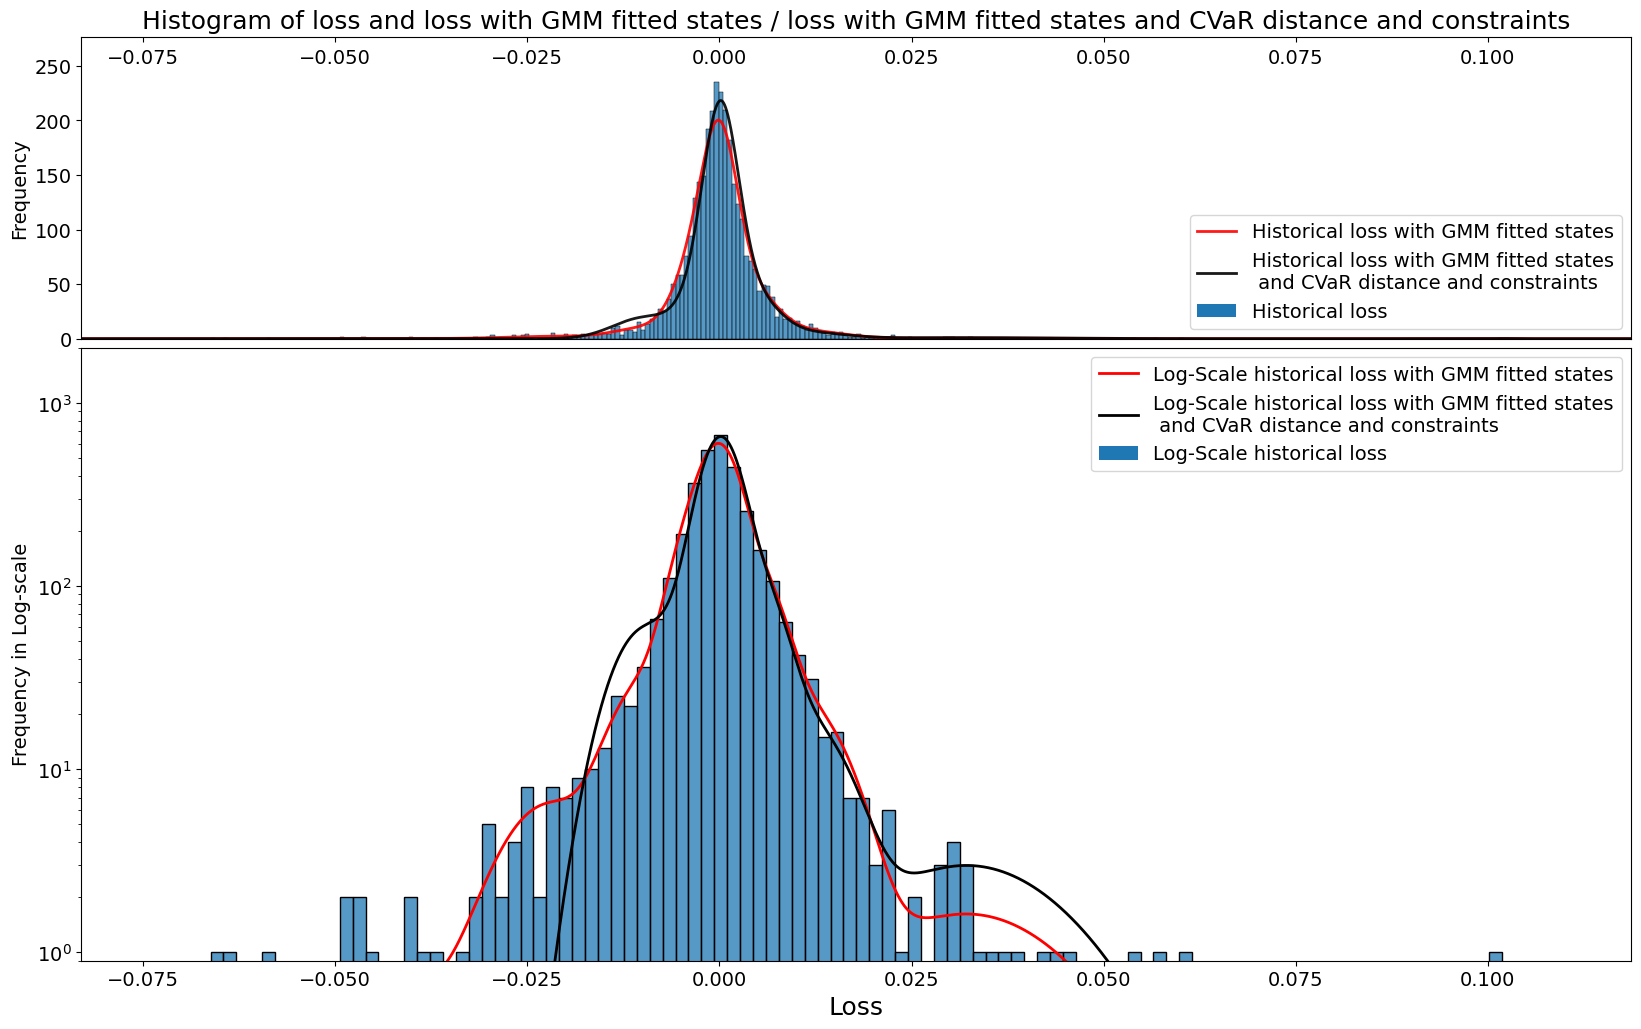

In [38]:
bin_num1, bin_num2 = 300, 100
x_range = loss_30min.max() - loss_30min.min()
xlim = [loss_30min.min() - 0.1 * x_range, loss_30min.max() + 0.1 * x_range]
x_vec = np.linspace(xlim[0], xlim[1], int(1e5))
gmm_vec = GMM_pdf(GMM_model["weight"], GMM_model["mean"], GMM_model["sigma"], x_vec)
gmm_vec1 = gmm_vec * np.histogram(loss_30min, bins=bin_num1)[0].max() / np.histogram(loss_30min, bins=bin_num1, density=True)[0].max()
gmm_vec2 = gmm_vec * np.histogram(loss_30min, bins=bin_num2)[0].max() / np.histogram(loss_30min, bins=bin_num2, density=True)[0].max()
gmmc_vec = GMM_pdf(GMM_model_cvar["weight"], GMM_model_cvar["mean"], GMM_model_cvar["sigma"], x_vec)
gmmc_vec1 = gmmc_vec * np.histogram(loss_30min, bins=bin_num1)[0].max() / np.histogram(loss_30min, bins=bin_num1, density=True)[0].max()
gmmc_vec2 = gmmc_vec * np.histogram(loss_30min, bins=bin_num2)[0].max() / np.histogram(loss_30min, bins=bin_num2, density=True)[0].max()

fig = plt.figure(figsize=(20, 12));
plt.subplots_adjust(hspace=0.03);

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1);
sns.histplot(data=loss_30min, bins=bin_num1, stat="count", ax=ax1, label="")
ax1.plot(x_vec, gmm_vec1, c="r", lw=2, alpha=0.9);
ax1.plot(x_vec, gmmc_vec1, c="k", lw=2, alpha=0.9);
ax1.set_xlim(xlim)
ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1]+30)
ax1.set_title('Histogram of loss and loss with GMM fitted states / loss with GMM fitted states and CVaR distance and constraints', fontsize=18)
ax1.set_xlabel('', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.tick_params(axis="x", labeltop=True, top=True, labelbottom=False, bottom=False, direction="in", pad=-22);
ax1.legend(["Historical loss with GMM fitted states","Historical loss with GMM fitted states\n and CVaR distance and constraints", "Historical loss"], loc="lower right", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2);
sns2 = sns.histplot(data=loss_30min, bins=bin_num2, stat="count", ax=ax2, label="Return histogram - Log-scale");
ax2.plot(x_vec, gmm_vec2, c="r", lw=2);
ax2.plot(x_vec, gmmc_vec2, c="k", lw=2);
sns2.axes.set_yscale('log')
ax2.set_ylim(0.9,2000);
ax2.set_xlim(xlim)
ax2.set_title('', fontsize=14)
ax2.set_xlabel('Loss', fontsize=18)
ax2.set_ylabel('Frequency in Log-scale', fontsize=14)
ax2.legend(["Log-Scale historical loss with GMM fitted states","Log-Scale historical loss with GMM fitted states\n and CVaR distance and constraints", "Log-Scale historical loss"], 
           loc="upper right", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);